In [1]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import metric_functions
from itertools import combinations
import cv2
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image, ImageOps
import glob
import sys, os
import json
import subprocess

In [2]:
#VAR declarations
#TODO manage this via config
all_metrics =  ['sre']
#all_frames = []
#maximum number of frames to capture
#max_frames = 150
comparison_frames = {}
keyframes = []
max_keyframes = 4
#fps = 60 #Some default here, what if fps not readable

parent_dir = "data/"
video_path = "data/videos/testvid.mov"
user_id = "0042"


In [3]:
#create necessary dictionaries
def create_folder_structure(user_id: str):
    #Create folder structure for new dataset and export names to .json file for further usage

    folder_dict = {
                "input": f"{user_id}_input",
                "mask": f"{user_id}_mask", 
                "models": f"{user_id}_models",
                "output": f"{user_id}_output",
                "target": f"{user_id}_target"
    }
      
    for key, directory in list(folder_dict.items()):
        path = os.path.join(parent_dir, directory)
        print(path)
        try:
            os.mkdir(path)
            print(f"{directory} successfully created")
        except OSError as error:
            print("Folder already exists. Skipping..")

    #add parent_dict to .json. This is necessary for keeping flexibility if refactoring is necessary
    folder_dict["ParentDir"] = parent_dir
    with open ("folderstructure.json", "w") as f:
        json.dump(folder_dict, f)


create_folder_structure(user_id)


data/0042_input
Folder already exists. Skipping..
data/0042_mask
Folder already exists. Skipping..
data/0042_models
Folder already exists. Skipping..
data/0042_output
Folder already exists. Skipping..
data/0042_target
Folder already exists. Skipping..


In [4]:
subprocess.call(["ffmpeg", "-i", video_path, f"{parent_dir}/{user_id}_input/frame_%4d.jpg"])

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/nea/miniconda3/envs/work-env --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1636205445100/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /

[hevc @ 0x7faf1687c400] Skipping NAL unit 62
[hevc @ 0x7faf16887400] Skipping NAL unit 62
[hevc @ 0x7faf16892400] Skipping NAL unit 62
[hevc @ 0x7faf1689d400] Skipping NAL unit 62
[hevc @ 0x7faf168a8400] Skipping NAL unit 62
[hevc @ 0x7faf168b3400] Skipping NAL unit 62
[hevc @ 0x7faf16838600] Skipping NAL unit 62
[hevc @ 0x7faf16846200] Skipping NAL unit 62
[hevc @ 0x7faf1682e600] Skipping NAL unit 62
[hevc @ 0x7faf1682ec00] Skipping NAL unit 62
[hevc @ 0x7faf1682f200] Skipping NAL unit 62
[hevc @ 0x7faf1682f800] Skipping NAL unit 62
[hevc @ 0x7faf16871400] Skipping NAL unit 62
[hevc @ 0x7faf1687c400] Skipping NAL unit 62
[hevc @ 0x7faf16887400] Skipping NAL unit 62
[hevc @ 0x7faf16892400] Skipping NAL unit 62
[hevc @ 0x7faf1689d400] Skipping NAL unit 62
[hevc @ 0x7faf168a8400] Skipping NAL unit 62
[hevc @ 0x7faf168b3400] Skipping NAL unit 62
[hevc @ 0x7faf16838600] Skipping NAL unit 62
[hevc @ 0x7faf16846200] Skipping NAL unit 62
[hevc @ 0x7faf1682e600] Skipping NAL unit 62
[hevc @ 0x

0

In [5]:
def get_fps() -> int:
    try:
        #Most common ID for webcams:
        #cap = cv2.VideoCapture(0)
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
    except cv2.error as error:
        print("[Error]: {}".format(error))
    cap.release()
    
    return int(fps)

In [6]:
all_frame_names = [name for name in glob.glob(f'data/{user_id}_input/*.jpg')]
#all_frames = [cv2.imread(frame) for frame in glob.glob(f'data/{user_id}_input/*.jpg')]
all_frame_names.sort()
all_frame_names
all_frame_data = [cv2.imread(frame) for frame in all_frame_names]

all_frames = list(zip(all_frame_names, all_frame_data))

fps = get_fps()
comparison_frames = dict(all_frames[::fps])
#dictionary = dict(zip(keys, values))
comparison_frames

{'data/0042_input/frame_0001.jpg': array([[[197, 193, 198],
         [197, 193, 198],
         [197, 193, 198],
         ...,
         [159, 175, 187],
         [159, 175, 187],
         [159, 175, 187]],
 
        [[197, 193, 198],
         [197, 193, 198],
         [197, 193, 198],
         ...,
         [159, 175, 187],
         [159, 175, 187],
         [159, 175, 187]],
 
        [[197, 193, 198],
         [197, 193, 198],
         [197, 193, 198],
         ...,
         [159, 175, 187],
         [159, 175, 187],
         [159, 175, 187]],
 
        ...,
 
        [[154, 209, 222],
         [154, 209, 222],
         [154, 209, 222],
         ...,
         [ 57,  92, 182],
         [ 56,  90, 183],
         [ 56,  90, 183]],
 
        [[154, 209, 222],
         [154, 209, 222],
         [154, 209, 222],
         ...,
         [ 58,  93, 183],
         [ 57,  91, 184],
         [ 57,  91, 184]],
 
        [[154, 209, 222],
         [154, 209, 222],
         [154, 209, 222],
        

In [7]:
def compare(df: pd.DataFrame, img_name_a: str, img_name_b: str, img_a: np.ndarray, img_b: np.ndarray, metrics: List[str]) -> pd.DataFrame:
    for metric in metrics:
        metric_func = metric_functions[metric]
        start_time = time.time()
        out_value = float(metric_func(img_a, img_b))
        end_time = time.time()
        output_dict = {}
        output_dict['metric'] = metric
        output_dict['x'] = img_name_a
        output_dict['y'] = img_name_b
        output_dict['value'] = out_value
        output_dict['walltime'] = end_time - start_time
        df = df.append(output_dict,ignore_index=True)
        output_dict['y'] = img_name_a
        output_dict['x'] = img_name_b
        df = df.append(output_dict,ignore_index=True)
        
    return df


,metric,x,y,value,walltime
0,sre,data/0042_input/frame_0001.jpg,data/0042_input/frame_0031.jpg,58.767216,0.040196
1,sre,data/0042_input/frame_0031.jpg,data/0042_input/frame_0001.jpg,58.767216,0.040196
2,sre,data/0042_input/frame_0001.jpg,data/0042_input/frame_0061.jpg,57.311195,0.023291
3,sre,data/0042_input/frame_0061.jpg,data/0042_input/frame_0001.jpg,57.311195,0.023291
4,sre,data/0042_input/frame_0001.jpg,data/0042_input/frame_0091.jpg,57.001334,0.022009
5,sre,data/0042_input/frame_0091.jpg,data/0042_input/frame_0001.jpg,57.001334,0.022009
6,sre,data/0042_input/frame_0001.jpg,data/0042_input/frame_0121.jpg,57.422930,0.020259
7,sre,data/0042_input/frame_0121.jpg,data/0042_input/frame_0001.jpg,57.422930,0.020259
8,sre,data/0042_input/frame_0001.jpg,data/0042_input/frame_0151.jpg,57.302288,0.019792
9,sre,data/0042_input/frame_0151.jpg,data/0042_input/frame_0001.jpg,57.302288,0.019792


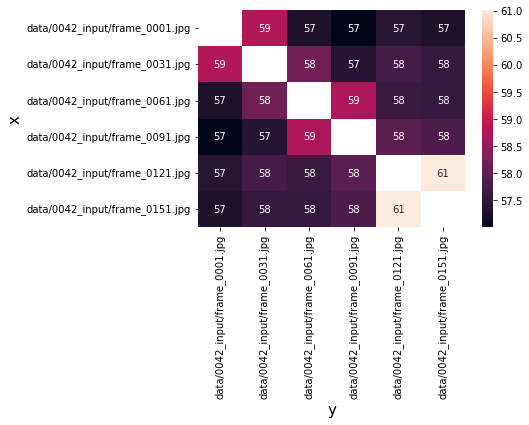

In [8]:
#Build some nice plots for better evaluation
#Select one metric and pivot the dataframe for creating the heatmap plot

df = pd.DataFrame()
for pair in combinations(comparison_frames.keys(), 2):
    #print(pair)
    #*pair : instead handing over a tuple(a,b) , hand over each element as separate argument a,b
    df = compare(df, *pair, comparison_frames[pair[0]], comparison_frames[pair[1]], all_metrics)
    
plot_df = df[df.metric == 'sre'].pivot('x', 'y', 'value')
ax = sns.heatmap(plot_df, annot=True)
df

In [9]:
def select_keyframes(comparison_frames: Dict[str,np.ndarray], max_keyframes: int) -> List[np.ndarray]:
    
    compare_options = list(combinations(comparison_frames.keys(), max_keyframes))
    compare_df = pd.DataFrame()
    
    #Calculate and accumalate the values on all 2-combinations of each 4-tuple
    #(frame_0, frame_13, frame_60, frame_115)
    # metric(frame_0,frame_13) + metric(frame_0,frame_60) +...
    for option in compare_options:
        value = 0.0
        for x, y in combinations(option, 2):
            #get the value of the current combination and square it
            #add to the final value of the 4-tuple
            value += plot_df[x][y] ** 2

        compare_df = compare_df.append({"option": option, "value": value}, ignore_index=True)

    # select the 4-tuple with lowest metric value as keyframes
    keyframes = list(compare_df.sort_values(by=['value'], ascending=True).iloc[0].option)
    
    return keyframes


In [10]:
keyframes = select_keyframes(comparison_frames, max_keyframes)
keyframes

['data/0042_input/frame_0001.jpg',
 'data/0042_input/frame_0061.jpg',
 'data/0042_input/frame_0091.jpg',
 'data/0042_input/frame_0151.jpg']

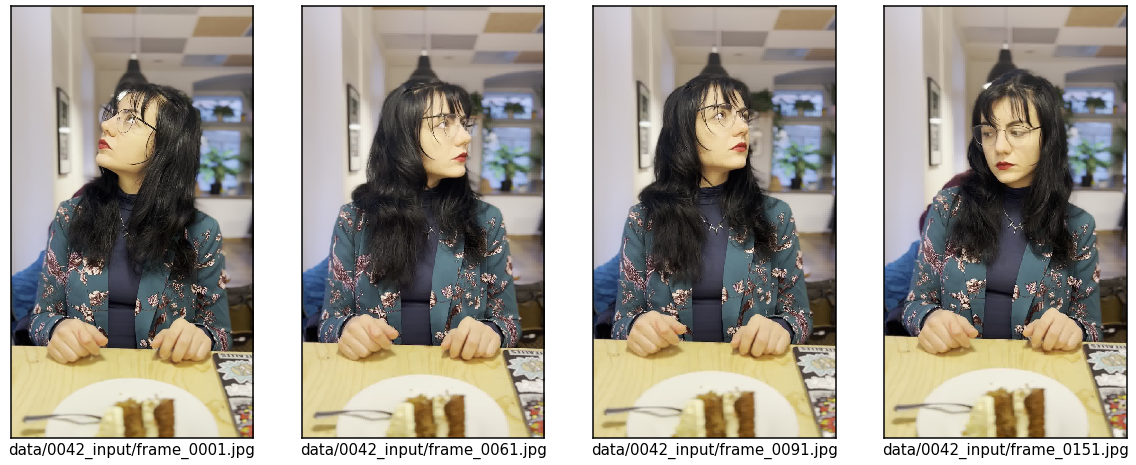

In [11]:
for img_name in keyframes:
    cv2.imwrite(img_name, comparison_frames[img_name])
    
xlen = len(keyframes)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img_path in zip(axes, keyframes):
    img = Image.open(img_path)
    isns.imgplot(img, ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(img_path)